In [1]:
# !pip install diffusers==0.21.4 transformers==4.35.0 accelerate==0.24.1 scipy==1.11.3 safetensors==0.4.0

In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from torch import nn
from torch import optim
from torchvision import utils
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 42
torch.manual_seed(seed=seed)
torch.set_float32_matmul_precision("high")

if device.type == 'cuda':
    torch.cuda.manual_seed_all(seed=seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## 1. Stable Diffusion을 활용하여 Text-to-image 생성하기

```
💡 사전학습된 Stable Diffusion 모델을 불러와 Text-to-image 생성을 실습해보고, 생성 과정을 자세히 살펴봅니다.
```

- 1-1. Stable Diffusion 모델 불러오기 및 Text-to-image 생성하기
- 1-2. Stable Diffusion 모델 파헤치기

### 1-1. Stable Diffusion 모델 불러오기 및 text-to-image 생성하기


Stable Diffusion은 스타트업 [Stability AI](https://stability.ai/)에서 개발한 text-to-image 생성을 위한 LDM(Latent Diffusion Model)으로 2022년 8월 오픈 소스로 공개되었습니다. Stable diffusion은 50억개가 넘는 이미지와 텍스트 조합을 포함하는 [LAION-5B](https://laion.ai/blog/laion-5b/) 데이터셋 중 일부를 사용하여 학습되었습니다.

![](https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/stable_diffusion.png)

Stable diffusion은 LDM 기반으로 기존 디퓨전 모델과 다르게 이미지 차원이 아니라 축소된 잠재 공간에서 diffusion 모델을 학습합니다. 이를 통해 VAE와 결합하여 고해상도 이미지를 다룰 수 있고 생성 과정이 빨라진다는 장점이 있습니다 (Stable Diffusion에서는 VQ-VAE가 아닌 VAE를 사용했습니다). 더불어 텍스트를 조건부로 입력 받아 text-to-image 생성이 가능하도록 학습이 되었습니다.


아래와 같이 Hugging Face 플랫폼에서 학습된 Stable diffusion 파이프라인을 불러올 수 있습니다. 본 실습에서는 Stable diffusion 2를 불러옵니다. Stable diffusion 1과 비교하여 텍스트 인코더로 학습 데이터셋이 공개되지 않은 CLIP 모델을 대체하여 [LAION-5B](https://laion.ai/blog/laion-5b/) 데이터셋으로 학습된 OpenCLIP 모델을 사용하여 생성 품질을 높일 수 있었다고 합니다. 다만, 회화적인 특징이나 유명인은 Stable diffusion 1에 비해 잘 표현하지 못한다고 합니다 [(링크)](https://www.assemblyai.com/blog/stable-diffusion-1-vs-2-what-you-need-to-know/).

파이프라인은 다음과 같이 구성됩니다.

- Scheduler: Diffusion 모델에서 노이즈 스케쥴링을 담당합니다. 몇 번 스텝을 거치는지, 매 시점마다 노이즈의 크기를 결정합니다. 디폴트 값으로 "DDIMscheduler"를 사용합니다.
- Text_encoder: CLIP 모델로 텍스트 임베딩을 계산합니다.
- Tokenizer: 텍스트를 토큰화 해줍니다.
- U-net: Diffusion 모델에서 노이즈를 예측합니다.
- VAE: VAE의 디코더가 생성 과정에서 잠재 벡터를 이미지로 변환합니다.


In [4]:
model_id = "stabilityai/stable-diffusion-2" # Stable diffusion v2

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16) # float16: 빠른 연산 가능
pipe = pipe.to("cuda")

/home/pervinco/miniconda3/envs/cls-project/lib/python3.9/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [31]:
prompt = "UEFA Champions League Final winner. Sonny"
image = pipe(prompt).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

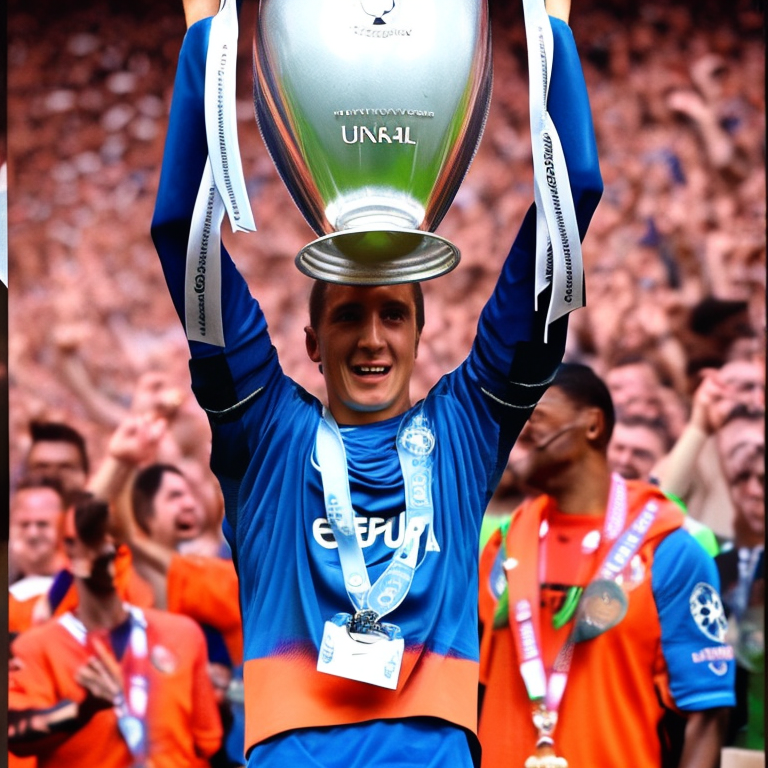

In [32]:
image

In [7]:
pipe.scheduler.compatibles # 사용 가능한 스케쥴러 목록

[diffusers.schedulers.scheduling_euler_ancestral_discrete.EulerAncestralDiscreteScheduler,
 diffusers.schedulers.scheduling_deis_multistep.DEISMultistepScheduler,
 diffusers.schedulers.scheduling_pndm.PNDMScheduler,
 diffusers.schedulers.scheduling_dpmsolver_singlestep.DPMSolverSinglestepScheduler,
 diffusers.schedulers.scheduling_unipc_multistep.UniPCMultistepScheduler,
 diffusers.schedulers.scheduling_ddpm.DDPMScheduler,
 diffusers.schedulers.scheduling_heun_discrete.HeunDiscreteScheduler,
 diffusers.schedulers.scheduling_ddim.DDIMScheduler,
 diffusers.schedulers.scheduling_lms_discrete.LMSDiscreteScheduler,
 diffusers.schedulers.scheduling_k_dpm_2_ancestral_discrete.KDPM2AncestralDiscreteScheduler,
 diffusers.schedulers.scheduling_dpmsolver_multistep.DPMSolverMultistepScheduler,
 diffusers.utils.dummy_torch_and_torchsde_objects.DPMSolverSDEScheduler,
 diffusers.schedulers.scheduling_euler_discrete.EulerDiscreteScheduler,
 diffusers.schedulers.scheduling_k_dpm_2_discrete.KDPM2Discret

In [8]:
from diffusers import EulerDiscreteScheduler

# DPMSolverMultistepScheduler 를 사용하여 이미지를 생성해봅니다.
pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)

In [9]:
prompt2 = "A chair that looks like an avocado"
image2 = pipe(prompt2).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

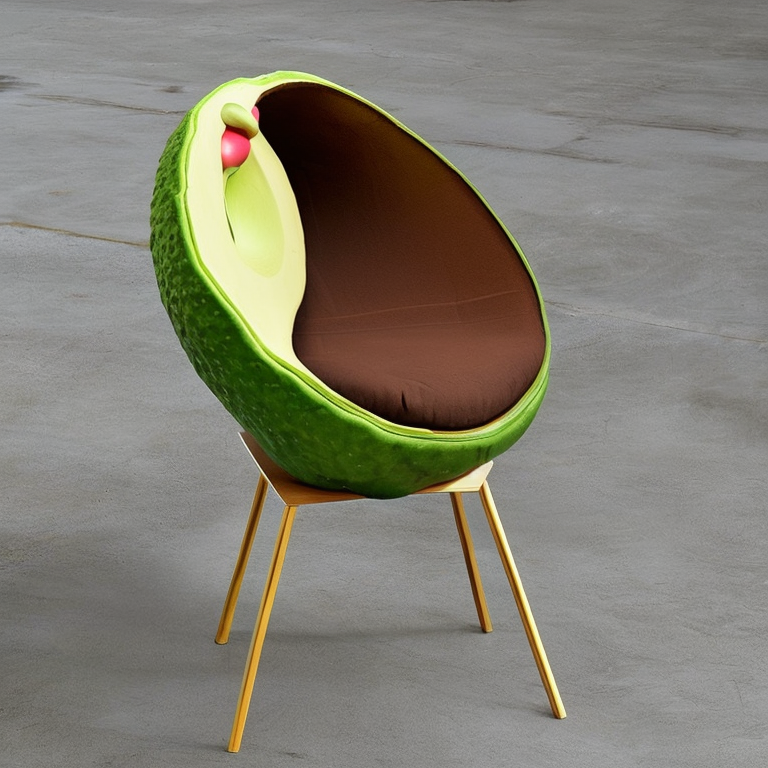

In [10]:
image2

### 1-2. Stable Diffusion 파이프라인 파헤치기

Stable Diffusion 모델의 파이프라인이 어떻게 작동하는지 살펴봅니다. 먼저 각 파이프라인의 구성 요소를 따로 불러와준 뒤 생성 과정에서 Classifier-free Guidance 기법을 활용하여 이미지를 생성합니다.

1. 각 파이프라인의 구성요소 불러오기
2. 시점 수 설정 및 Guidance 스케일 설정
3. Prompt를 Token으로 변환한 뒤 텍스트 임베딩 계산
4. Classifier-free guidance를 위해 빈 문장("")을 token으로 변환한 뒤 텍스트 임베딩 계산
5. 잠재벡터를 정규분포에서 랜덤추출
6. 디노이징 과정을 거쳐 이미지 생성

In [11]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, DDIMScheduler

# 1. 각 모듈의 학습된 가중치는 subfolder 옵션을 추가하여 불러올 수 있습니다.
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")
scheduler = DDIMScheduler.from_pretrained(model_id, subfolder="scheduler")

/home/pervinco/miniconda3/envs/cls-project/lib/python3.9/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [12]:
# 모듈을 GPU 위에 올리고 평가 모드로 전환합니다.
vae = vae.to("cuda").eval()
text_encoder = text_encoder.to("cuda").eval()
unet = unet.to("cuda").eval()

In [13]:
# 2.Guidance의 스케일과 기타 hyperparameter를 설정합니다.
prompt = ["a photograph of an astronaut riding a horse"]
height = 768  # Stable Diffusion의 높이
width = 768  # Stable Diffusion의 너비
num_inference_steps = 50  # 노이즈 제거 스텝 수
guidance_scale = 7.5  # classifier-free guidance를 위한 scale
generator = torch.manual_seed(42)  # 초기 잠재 노이즈를 생성하는 seed generator
batch_size = len(prompt)

In [14]:
# 3. 제시된 Prompt를 Token으로 변환합니다
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)

# 텍스트 임베딩을 계산합니다
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to("cuda"))[0]

In [15]:
# 4. Classifier-free Guidance를 위해 빈 문장에 대한 임베딩을 계산합니다.
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")

with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to("cuda"))[0]

In [16]:
# 앞서 계산한 두 개의 텍스트 임베딩을 합쳐 최종 텍스트 임베딩을 얻습니다
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [17]:
# 5. 잠재벡터를 정규분포에서 랜덤 추출합니다
latents = torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),
    generator=generator,
)
latents = latents.to("cuda")
# latents = latents * scheduler.init_noise_sigma # DDIMScheduler에서는 init_noise_sigma = 1.0

In [18]:
from tqdm.auto import tqdm # progress bar를 출력하기 위한 모듈

# 6. 디노이징 과정
scheduler.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):
    # classifier-free guidance를 수행하는 경우 두번의 forward pass를 수행하지 않도록 latent를 확장.
    latent_model_input = torch.cat([latents] * 2)

    # 각 시점마다 입력 데이터의 스케일을 조정합니다 (DDIMScheduler에서는 스케일을 조정하지 않음)
    # latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # noise residual 예측
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # guidance 수행
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # (t-1)시점 노이즈 샘플을 계산 x_{t} -> x_{t-1}
    latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/50 [00:00<?, ?it/s]

In [19]:
# latent를 스케일링하고 vae로 이미지 디코딩
# vae.config.scaling_factor = 0.18215 (temperature sampling)
with torch.no_grad():
    image = vae.decode(latents / vae.config.scaling_factor).sample

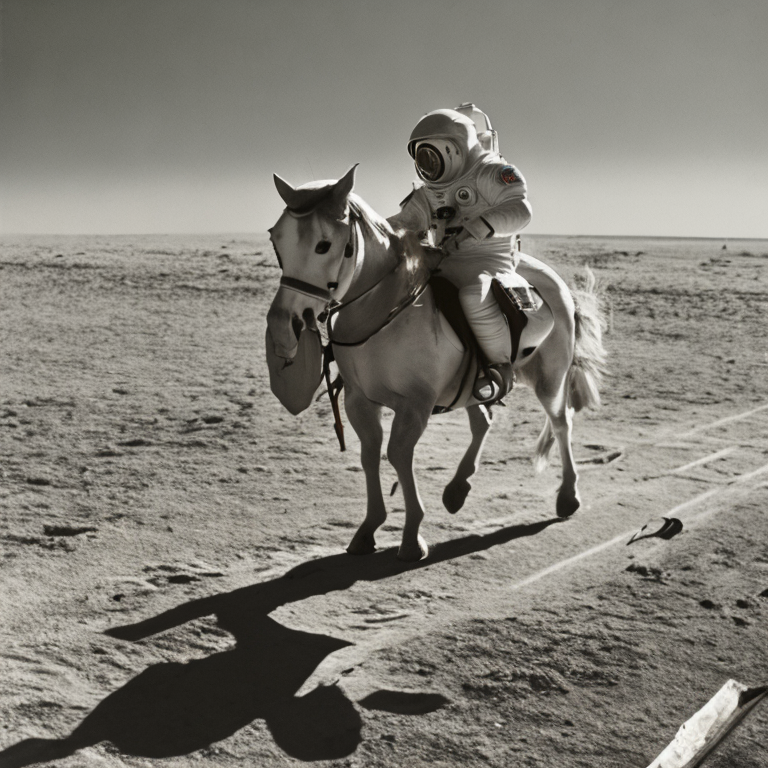

In [20]:
from PIL import Image

image = (image * 0.5 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

#Reference

- [Stable diffusion 오픈 소스 공개](https://stability.ai/blog/stable-diffusion-public-release)
- [HuggingFace: Stable diffusion v2](https://huggingface.co/stabilityai/stable-diffusion-2-1)
- [Stable diffusion 튜토리얼 (한국어 버전)](https://huggingface.co/docs/diffusers/v0.21.0/ko/using-diffusers/write_own_pipeline#stable-diffusion)